In [1]:
from matplotlib import pyplot as plt
import numpy as np
from dune.grid import cartesianDomain
from dune.grid import yaspGrid
from dune.alugrid import aluConformGrid
#from dune.grid import reader
#from dune. import gmsh2DGF
from dune.fem.utility import gridWidth
import pygmsh

DUNE-INFO: yasp coordinates dim=2 ctype=double (rebuilding)
DUNE-INFO: HierarchicalGrid (rebuilding)


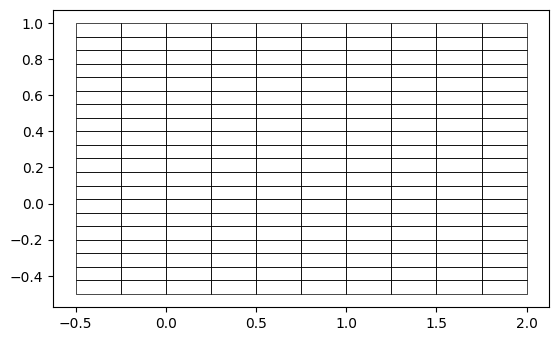

In [35]:
# Task 5
domain = cartesianDomain([-.5, -.5], [2, 1], [10, 20])
gridView = yaspGrid(domain)
gridView.plot()

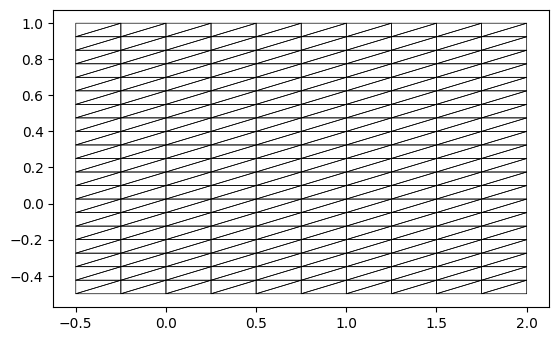

In [42]:
# Task 6
aluView = aluConformGrid(domain)
aluView.plot()

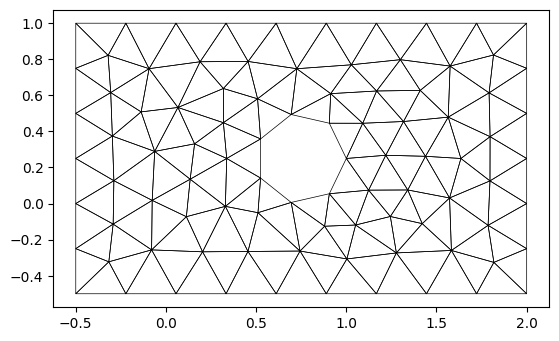

In [36]:
# Task 8
def generateHoleGrid():
    with pygmsh.occ.Geometry() as geom:
        L = 2.5
        H = 1.5
        x_hole = (-0.5+L/2)
        y_hole = (-0.5+H/2)
        radius = 0.25
        rectangle = geom.add_rectangle([-.5, -.5, 0], L, H)
        disk = geom.add_ball([x_hole, y_hole, 0], radius)
        geom.boolean_difference(rectangle, disk)
        mesh = geom.generate_mesh(dim=2)
    # Generate domain
    points, cells = np.array([np.array([x, y]) for x, y, z in mesh.points]), mesh.cells_dict
    #print(type(points), points[0])
    #print(cells.keys())
    domain = {"vertices":points.astype("float"), "simplices":cells["triangle"]}
    return aluConformGrid(domain, dimgrid=2)
# Generate grid
holeGridView = generateHoleGrid()
holeGridView.plot()

In [37]:
# Task 9
def ourGridWidth(gridView):
    # Compute the max distance between corners within each triangle
    # Equivalently, this is the longest edge
    # The gridWidth of the grid is the largest such distance on the grid
    # codim of one -> edges (2nd level elements)
    return np.max([edge.geometry.volume for edge in gridView.entities(codim=1)])

def ourDuneGridWidth(gridView):
    # Try to recover the same grid width value that Dune computes
    # This is min over the elements of |E|/min(|e|) over all e in E.
    # Equivalently, it is the min over all E of the max of |E|/|e| for all e in E
    # In the 2D case, this should be the minimum area divided by minimum side length across the grid
    h_min = 10**6
    for entity in gridView.entities(codim=0):
        # Divide the area of the triangle by the length of each side
        # If smaller than h_min, replace
        area = entity.geometry.volume
        shortest_edge = np.min([edge.geometry.volume for edge in entity.subEntities(codim=1)])
        #element_min = np.max([area/edge.geometry.volume for edge in entity.subEntities(codim=1)])
        element_min = area/shortest_edge
        if element_min < h_min:
            h_min = element_min
    return h_min

# Grid width our version
ourWidth = ourGridWidth(holeGridView)
# Our dune implementation
ourDuneWidth = ourDuneGridWidth(holeGridView)
# Dune implementation
duneWidth = gridWidth(holeGridView)
print(f"Our final grid width: {ourWidth:.5f}")
print(f"Our calculation of Dune's grid width: {ourDuneWidth:.5f}")
print(f"Dune grid width: {duneWidth:.5f}")

Our final grid width: 0.31554
Our calculation of Dune's grid width: 0.08482
Dune grid width: 0.04241


In [38]:
# Task 10
from dune.fem.function import gridFunction
from dune.common import FieldVector

# Piece-wise constant grid function that measures the grid width on each element
@gridFunction(holeGridView, name="GridWidth", order=1)
def gridWidthFunction(element, _): # Second parameter for compatibility with the f(e, x) signature expected by dune
    # D_max = 0
    # corners = np.array(element.geometry.corners)
    # for i in range(len(corners)):
    #     for j in range(i+1, len(corners)):
    #         D = np.sqrt(np.sum((corners[i]-corners[j])**2))
    #         if D > D_max:
    #             D_max = D
    return np.max([edge.geometry.volume for edge in element.subEntities(codim=1)])

# Get max value using the grid function
maxValue = np.max([gridWidthFunction(e, 0) for e in gridWidthFunction.gridView.elements]) # Again, call with second dummy argument to avoid global lookup (hangs program)
print(f"Max width of an element: {maxValue:.5f}")

Max width of an element: 0.31554


In [39]:
# Task 11
# Create a DoF mapper which assigns one DoF to each vertex (dim=0) in the grid
mapper = holeGridView.mapper(lambda gt: 1 if gt.dim==0 else 0)
# Print the degrees of freedom
print(f"This map has {mapper.size} degrees of freedom")
# Print number of vertices
print(f"There are {len([v for v in holeGridView.vertices])} vertices in the grid")

This map has 92 degrees of freedom
There are 92 vertices in the grid


In [32]:
v0 = [v for v in holeGridView.vertices][0]
print(v0.geometry.center)

(-0.500000, -0.500000)


In [33]:
e0 = [e for e in holeGridView.elements][0]
data = np.zeros(mapper.size)
print(e0.vertices)
print([mapper.index(v) for v in e0.vertices])
print(mapper.subIndices(e0, holeGridView.dimension))
print(data[np.array(mapper.subIndices(e0, holeGridView.dimension))])

(<dune.generated.hierarchicalgrid_d827e80243feae36e8b9006bb24207e7.LeafGrid.Entity_2 object at 0x7a579b52daf0>, <dune.generated.hierarchicalgrid_d827e80243feae36e8b9006bb24207e7.LeafGrid.Entity_2 object at 0x7a579b52c4b0>, <dune.generated.hierarchicalgrid_d827e80243feae36e8b9006bb24207e7.LeafGrid.Entity_2 object at 0x7a579c4e4e70>)
[0, 1, 2]
(0, 1, 2)
[0. 0. 0.]


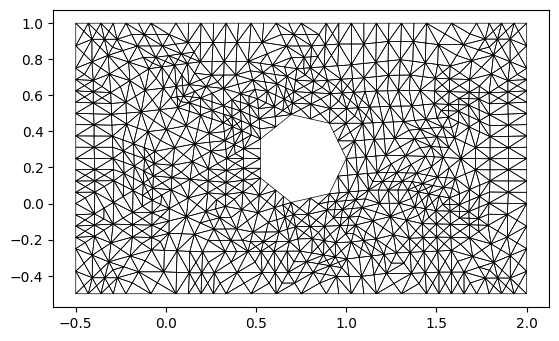

In [46]:
# Refine the grid three times globally
holeGridView.hierarchicalGrid.globalRefine(3)
holeGridView.plot()

In [40]:
help(mapper.subIndices)

Help on method subIndices in module dune.generated.mcmgmapper_b8be5d29e335e70e9fbad6680d441a60:

subIndices(...) method of dune.generated.mcmgmapper_b8be5d29e335e70e9fbad6680d441a60.MultipleCodimMultipleGeomTypeMapper instance
    Args:
        entity:     an entity of the grid
        codim:      codimension of a subentity of `entity`

    Returns: indices of dofs attached to all subentity
             of codimension `codim` of the given entity.



0.047452896578485344
0.167342716351316
0.159520024894212
0.13440333671267482
0.34589172393577133


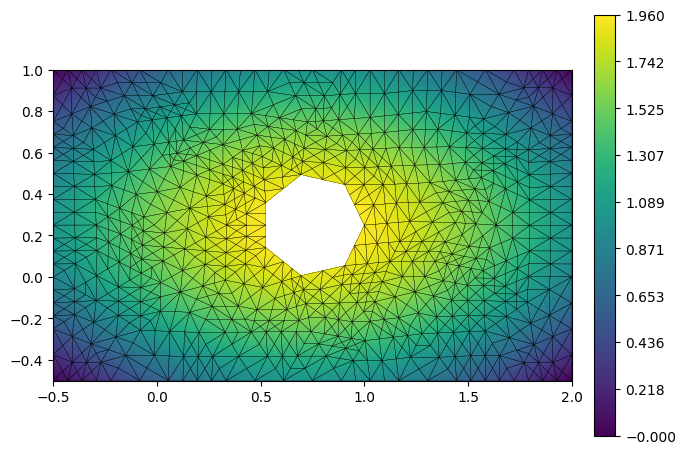

In [47]:
# Task 12
# Part 1: Create a function linearInterpolation that takes a grid function u and a gridView
# It should return a mapper and vector of DoF values from u on the vertices
def linearInterpolation(u, gridView):
    # Create a mapper
    mapper = gridView.mapper(lambda gt: 1 if gt.dim==0 else 0) # 1 DoF per vertex
    # Vector for values
    dof_vec = np.zeros(mapper.size)
    # Iterate through the vertices, applying u at each one
    for vertex in gridView.vertices:
        idx = mapper.index(vertex)
        dof_vec[idx] = u(vertex.geometry.center)
    return mapper, dof_vec

# Part 2: Create a grid function uh that linearly interpolates given the mapper and dof vector
# In this case, we first create a callable class so we can attach state variables containing the mapper,
# dof_vec, and grid view
class LinearInterpolator():
    def __init__(self, mapper, dof_vec):
        self.mapper = mapper
        self.data = dof_vec
    def __call__(self, element, x):
        # The actual grid function
        # Compute u(p0)(1-x0-x1) + u(p1)x0 + u(p2)x1
        # Indices of vertices in the DoF vector
        #indices = np.array(self.mapper.subIndices(element, self.gridView.dimension))
        indices = np.array([self.mapper.index(v) for v in element.vertices])
        u_arr = self.data[indices] # u(p0), u(p1), u(p2)
        x_arr = np.array([1-x[0]-x[1], x[0], x[1]])
        #print(f"data for vertices: {u_arr}, interpolation coeffs: {x_arr}, original pt input: {x}")
        return np.dot(u_arr, x_arr)

@gridFunction(holeGridView, name='x+y', order=1)
def xplusy(x):
    return np.sum(x)
@gridFunction(holeGridView, name='Sine', order=1)
def sin(x):
    return np.sin(np.pi*(x[0]+0.5)/2.5) + np.sin(np.pi*(x[1]+0.5)/1.5)

# Get the mapper and DoF vector using some function
# In this case, testing with a linear function
mapper, data = linearInterpolation(sin, holeGridView)

# Define the callable class as a grid function using this mapper and data
uh = gridFunction(holeGridView, name='Interpolation of x', order=1)(LinearInterpolator(mapper, data))

point = FieldVector([0.2, 0.2])
for i, e in enumerate(uh.gridView.elements):
    #print(e.geometry.center)
    #print([v.geometry.center for v in e.vertices])
    #print([data[mapper.index(v)] for v in e.vertices])
    print(uh(e, point))
    if i == 4:
        break
#xplusy.plot()
uh.plot()

In [37]:
for i, e in enumerate(holeGridView.elements):
    print(e.geometry.center)
    print(e.geometry.toLocal(e.geometry.center))
    print(e.geometry.toGlobal(e.geometry.center))
    #print([v.geometry.center for v in e.vertices])
    #print([data[mapper.index(v)] for v in e.vertices])
    #print(uh(e, point))
    if i == 1:
        break

(-0.461585, -0.485243)
(0.333333, 0.333333)
(-0.554838, -0.520434)
(-0.431051, -0.455730)
(0.333333, 0.333333)
(-0.484717, -0.454638)


Maximum interpolation error: 5.39885e-03


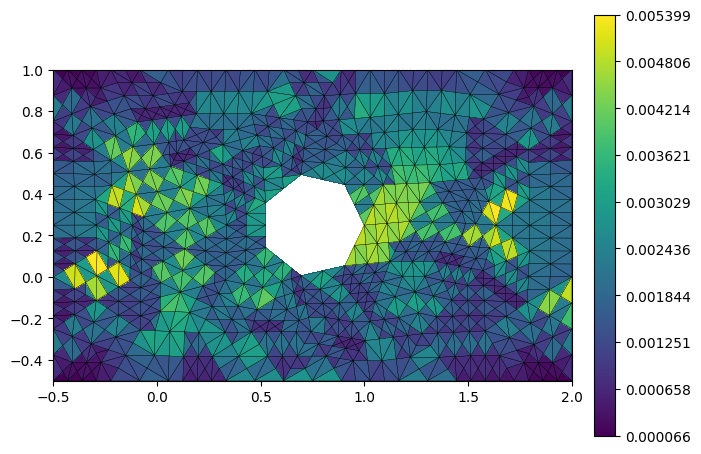

In [48]:
# Task 13
# Compute the maximum interpolation error by comparing uh at the center
# of each element to the value of u there.
# Write a grid function which computes the error for an element
class InterpolationError():
    def __init__(self, u, uh):
        self.u = u
        self.uh = uh
    def __call__(self, element, x):
        # The actual grid function
        # For element, get center w_E and compute |u(w_E)-uh(w_E)|
        # Note that u expects global coordinates and uh works with local
        # coordinates inside each reference element
        global_center = element.geometry.center # Global coordinate
        local_center = FieldVector([1./3, 1./3]) # Center of the reference element
        err = np.abs(self.u(global_center)-self.uh(element, local_center))
        return err
# Define the u
u = sin #xplusy # vec X -> x+y
# Create the grid function using the wrapper class to store u and uh
interp_error = gridFunction(holeGridView, name='Error', order=1)(InterpolationError(u, uh))

# Compute the maximal error value using the function
maxErr = np.max([interp_error(e, 0) for e in interp_error.gridView.elements])
print(f"Maximum interpolation error: {maxErr:.5e}")
interp_error.plot()

In [50]:
# Task 14
# Compare the maximal error at different refinement levels
roughGrid = generateHoleGrid() # Basic grid
fineGrid = generateHoleGrid()
fineGrid.hierarchicalGrid.globalRefine(5) # 5 times refined
# Rough error
print("Rough grid: default")
#@gridFunction(roughGrid, name='x+y rough', order=1)
#def xplusy_rough(x):
#    return np.sum(x)
# Get the mapper and DoF vector for this grid
mapper, data = linearInterpolation(u, roughGrid)
print(f"Rough grid has {len(data)} DoF, grid width {gridWidth(roughGrid):.5e}")
# Define uh and interpolation error on this grid
uh_rough = gridFunction(roughGrid, name='Interpolation of x+y on a rough grid', order=1)(LinearInterpolator(mapper, data))
interp_error_rough = gridFunction(roughGrid, name='Error', order=1)(InterpolationError(u, uh_rough))
roughErr = np.max([interp_error_rough(e, 0) for e in roughGrid.elements])
print(f"Maximum interpolation error: {roughErr:.5e}")
# Error from before with 3 refines
print("Intermediate grid: 3x refined")
print(f"Intermediate grid has {len([v for v in holeGridView.vertices])} DoF, grid width {gridWidth(holeGridView):.5e}")
print(f"Maximum interpolation error: {maxErr:.5e}")
# Fine error
print("Fine grid: 5x refined")
# @gridFunction(fineGrid, name='x+y fine', order=1)
# def xplusy_fine(x):
#     return np.sum(x)
# Get the mapper and DoF vector for this grid
mapper, data = linearInterpolation(u, fineGrid)
print(f"Fine grid has {len(data)} DoF, grid width {gridWidth(fineGrid):.5e}")
# Define uh and interpolation error on this grid
uh_fine = gridFunction(fineGrid, name='Interpolation of x+y on a fine grid', order=1)(LinearInterpolator(mapper, data))
interp_error_fine = gridFunction(fineGrid, name='Error', order=1)(InterpolationError(u, uh_fine))
fineErr = np.max([interp_error_fine(e, 0) for e in fineGrid.elements])
print(f"Maximum interpolation error: {fineErr:.5e}")

Rough grid: default                                                                                                          
Rough grid has 92 DoF, grid width 4.24098e-02
Maximum interpolation error: 3.08331e-02
Intermediate grid: 3x refined
Intermediate grid has 911 DoF, grid width 7.80941e-03
Maximum interpolation error: 5.39885e-03
Fine grid: 5x refined
Fine grid has 3904 DoF, grid width 3.47695e-03
Maximum interpolation error: 1.35778e-03


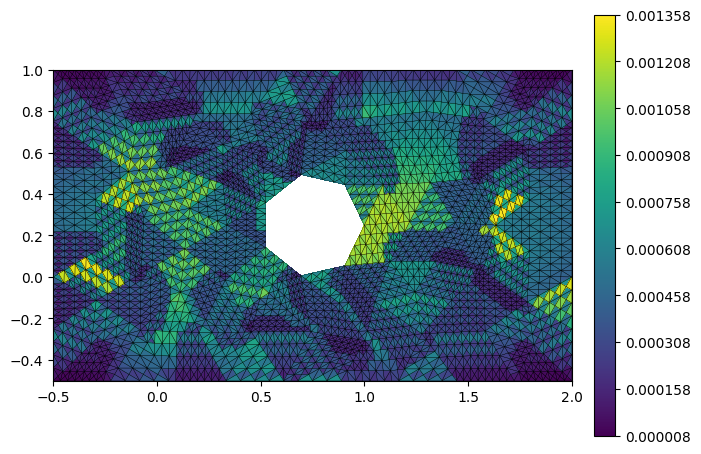

In [53]:
interp_error_fine.plot()

0 refinements, grid width: 0.042409819539036504, error: 3.08331e-02                                                          
1 refinements, grid width: 0.02429833900650479, error: 2.10709e-02
2 refinements, grid width: 0.01243744411213594, error: 1.28975e-02
3 refinements, grid width: 0.007809413148284546, error: 5.39885e-03
4 refinements, grid width: 0.005603678725057897, error: 3.28853e-03
5 refinements, grid width: 0.00347695142883696, error: 1.35778e-03
6 refinements, grid width: 0.0023648635239754703, error: 8.26298e-04
7 refinements, grid width: 0.0015266381932765689, error: 3.39926e-04
8 refinements, grid width: 0.0008692378572092537, error: 2.06852e-04


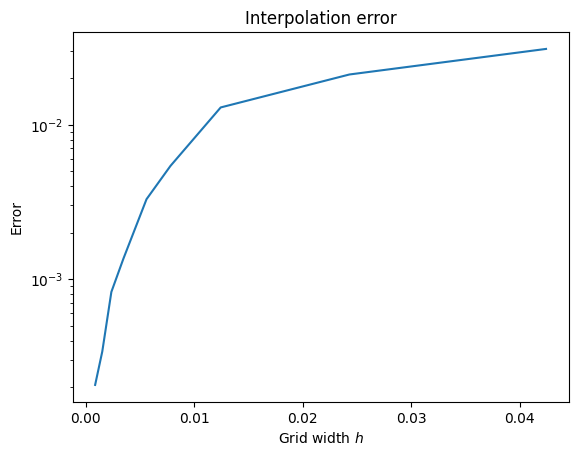

In [55]:
# Refine N times, computing the interpolation error of u for the base grid and the
# N refinements
# Plot h vs err
def hvserr(u, N, plot=True):
    gridView = generateHoleGrid()
    hs = np.zeros(N+1)
    errs = np.zeros(N+1)
    for i in range(N+1):
        # Get the mapper and DoF vector for this grid
        mapper, data = linearInterpolation(u, gridView)
        # Save grid width
        hs[i] = gridWidth(gridView)
        # Define uh and interpolation error on this grid
        uh = gridFunction(gridView, name='Interpolation of u', order=1)(LinearInterpolator(mapper, data))
        interp_error = gridFunction(gridView, name='Error', order=1)(InterpolationError(u, uh))
        # Save maximum error
        errs[i] = np.max([interp_error(e, 0) for e in gridView.elements])
        print(f"{i} refinements, grid width: {hs[i]}, error: {errs[i]:.5e}")
        # Refine the grid
        gridView.hierarchicalGrid.globalRefine(1)
    # Plot
    if plot:
        fig, ax = plt.subplots(1, 1)
        ax.semilogy(hs, errs)
        ax.set_xlabel(r"Grid width $h$")
        ax.set_ylabel("Error")
        ax.set_title("Interpolation error")
        plt.show()
    return hs, errs

hs, errs = hvserr(u, 8)